# 15688 Midterm Tutorial 

## Introduction

This toturial focuses on the data analysis towards taxi trip dataset. I decide to choose this topic because of the close relationship with our daily life and the potential valuable benefits these data might bring to our society. For example if we know the data about the average taxi trip distance, we might be able to predict the types of people that commonly uses taxi as their transportation tool. Similar small but important issues includes predicting the tips as a percentage of the total taxi fare. And all of them are closely related to our daily life.

## Toturial dataset 

The dataset in this tutorial comes from NYC TLC's record dataset which records the taxi trip data in the every months from 2009 to 2017 in New York City. The detailed description can be found in http://www.nyc.gov/html/tlc/html/about/about.shtml. In this tutorial we're gonna focus on the green taxi's data in September 2015. The link for that dataset is http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml. This dataset is the raw dataset of 239MB for green taxi which have 21 raw columns in total. Detailed data dictionary can be found on that page as well.

## Structure of this tutorial

Then main structure is as follows: 
1. [Environment Preparation](#1.-Environment-Preparation)
2. [Dataset Overview](#2.-Dataset-Overview)
3. [Main Tasks](#3.-Main-tasks)  
    3.1. [Analyze taxi trip distance data](#3.1-Analyze-taxi-trip-distance-data)     
    3.2. [Build prediction model for predicting tip as a percentage of the total fare](#3.2-Build-prediction-model-for-predicting-tip-as-a-percentage-of-the-total-fare)
    
4. [Summary and reference](#4.-Summary-and-reference)

So let's start now!

## 1. Environment Preparation

In order to run the code smoothly, you need to do the following steps: 
1. If you already have Anaconda, leave this out. Otherwise, since the tutorial requires Python 3+, you can just download Anaconda in https://www.anaconda.com/download/ which also contains most other necessary libraries for this tutorial. 
2. For the model construction part, I used Pytorch. If you haven't install pytorch, first make sure you have followed step 1, then Simply type in command line: 

    $ conda install pytorch torchvision -c pytorch  

Here you go! The above steps should be enough. But if you come across some problem, please refer to the corresponding forums or stackoverflow for more details.


The following is the necessary libraries for thie tutorial:

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import torch
import math
import time
import os
from torch.utils.data import Dataset,DataLoader, TensorDataset
from torch.optim.lr_scheduler import *
matplotlib.use("svg")
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## 2. Dataset Overview

Before directly moving to our main tasks, I'd like to first give you a overview about what the data is like. If you have downloaded the data, please put the dataset in the same directory as this tutorial; if not that's fine, I'll handle that for you by automatically downloading it.   

In [2]:
# load our csv data
if os.path.exists('green_tripdata_2015-09.csv'):
    green_trip_pd=pd.read_csv('green_tripdata_2015-09.csv')
else:
    print('download')
    green_trip_pd=pd.read_csv('https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv')
# get numbers of rows and columns
row_num=len(green_trip_pd)
column_num=len(green_trip_pd.columns)

# let's see the results!
print('row number:',row_num,",column number:",column_num)
print('column name:',green_trip_pd.columns)
print('data type:',green_trip_pd.dtypes)

download
row number: 1494926 ,column number: 21
column name: Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type '],
      dtype='object')
data type: VendorID                   int64
lpep_pickup_datetime      object
Lpep_dropoff_datetime     object
Store_and_fwd_flag        object
RateCodeID                 int64
Pickup_longitude         float64
Pickup_latitude          float64
Dropoff_longitude        float64
Dropoff_latitude         float64
Passenger_count            int64
Trip_distance            float64
Fare_amount              float64
Extra                    float64
MTA_tax                  float64
Tip_amount               float64
Tolls_

And now from the results above, we have a overview about what the data we're going to analyze is like. But before we move on to our main tasks, I think it'll be of great help if we can do some pre-processing work.  

We need to formalize the data: I'd like to transfrom type of lpep_pickup_datetime and Lpep_dropoff_datetime to datetime64[ns], and transform Store_and_fwd_flag into int value (0,1). First we need to remove empty/None value:

In [3]:
# check valid time
checkdrop=green_trip_pd['Lpep_dropoff_datetime'].replace('',np.nan)
print(checkdrop.isnull().sum())
checkpick=green_trip_pd['lpep_pickup_datetime'].replace('',np.nan)
print(checkpick.isnull().sum())
checkflag=green_trip_pd['Store_and_fwd_flag'].replace('',np.nan)
print(checkpick.isnull().sum())

0
0
0


Lucky! Then we can perform transformation without any further worries:

In [4]:
# pre-processing : transform data type
green_trip_pd['lpep_pickup_datetime']=green_trip_pd['lpep_pickup_datetime'].astype('datetime64[ns]')
green_trip_pd['Lpep_dropoff_datetime']=green_trip_pd['Lpep_dropoff_datetime'].astype('datetime64[ns]')
green_trip_pd['Store_and_fwd_flag']=green_trip_pd['Store_and_fwd_flag'].replace('Y',1).replace('N',0)
print(green_trip_pd.dtypes)


VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
Lpep_dropoff_datetime    datetime64[ns]
Store_and_fwd_flag                int64
RateCodeID                        int64
Pickup_longitude                float64
Pickup_latitude                 float64
Dropoff_longitude               float64
Dropoff_latitude                float64
Passenger_count                   int64
Trip_distance                   float64
Fare_amount                     float64
Extra                           float64
MTA_tax                         float64
Tip_amount                      float64
Tolls_amount                    float64
Ehail_fee                       float64
improvement_surcharge           float64
Total_amount                    float64
Payment_type                      int64
Trip_type                       float64
dtype: object


There several issues I'd like to emphasize:  
1. When we do these transformation, it's actually not safe by the steps above since it's possible there might be other strings rather than 'Y' or 'N' in the Store_and_fwd_flag colum, or the time for lpep_pickup_datetime might just be a random strings.I did the above codes simply because the data source is kind of reliable. It's always a good habit to do more checking about original the data type.  
2. Our pre-processing steps are far away from enough only by the above steps. Pre-processing data before conducting any analysis is extremely important in data science, because most of the data we get from real world would suffer greatly from wrong information, noisy data and useless statistics. I'll do more pre-processing work in later stages.  

## 3. Main tasks

Now let's move on to the most desirable part and begin our exploration! First let's analyze the taxi trip distance data and see whether we can find something interesting.

### 3.1 Analyze taxi trip distance data

#### 3.1.1 Histogram of trip distance data and analysis

Since I think the taxi trip distance is one of the core features with which many other features and findings are correlated, let's first take a look at its histogram to find possible trend:

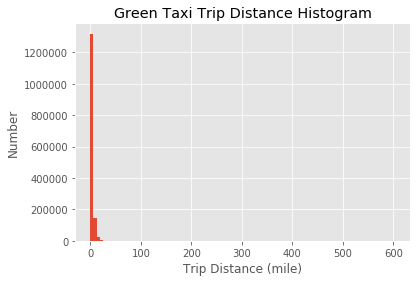

In [5]:
trip_dis=green_trip_pd['Trip_distance']

plt.hist(trip_dis,bins=100)
plt.title('Green Taxi Trip Distance Histogram')
plt.xlabel('Trip Distance (mile)')
plt.ylabel('Number')

plt.show()

This didn't work well: the graph above cannot give a precise description of the Trip_distance's distribution information. In order to have a better understanding of the structure, first let's see the statistic attributes of this column: 

In [6]:
print(trip_dis.describe())

count    1.494926e+06
mean     2.968141e+00
std      3.076621e+00
min      0.000000e+00
25%      1.100000e+00
50%      1.980000e+00
75%      3.740000e+00
max      6.031000e+02
Name: Trip_distance, dtype: float64


If you run the codes above, you can see that 75% trip only has a really short distance within 3.74 miles. So let's only consider more common results, say trips that are within 25 miles:

Text(0,0.5,'Number')

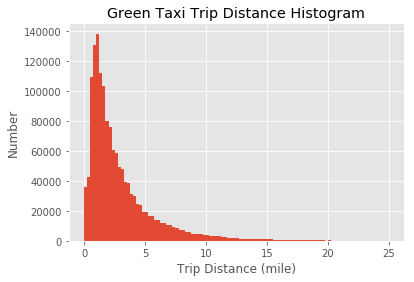

In [7]:
trip_dis_short=trip_dis[trip_dis<25]

plt.hist(trip_dis_short,bins=100)
plt.title('Green Taxi Trip Distance Histogram')
plt.xlabel('Trip Distance (mile)')
plt.ylabel('Number')

The first finding is that this distribution is kind of skewed, actually is just the log normal distribution. And the reason that the majority of the distance is short trip (<10) might be that the data is taken from NYC, the world famous big and busy city which doesn't quite favor long distance trip. It's more common for people driving to work, driving home, driving for shopping than driving for a long travel. As for other possible factors we'll discover the relationship in the later stages.

#### 3.1.2 Find relationship between trip distance and trip time

How about the relationship between trip distance and time? For better analysis we're gonna to represent one day's time by its hour, and we'll group the trip distance by hour of day first, then focus on the mean and median trip distance at different time. Notice I'll use Lpep_dropoff_datetime column's hour to represent the hour of a trip just feels like it's more intuitive for me, you can try lpep_pickup_datetime as well:)

In [8]:
green_trip_pd['hour']=green_trip_pd['Lpep_dropoff_datetime'].apply(lambda x:x.hour)
hour_trip=green_trip_pd[['hour','Trip_distance']].groupby(green_trip_pd['hour'])

# mean of trip distance for different hour period
# print('Trip mean')
# print(hour_trip.mean()['Trip_distance'])
# print('trip median')
# print(hour_trip.median()['Trip_distance'])

And we can draw the line chart for mean and median trip distance:

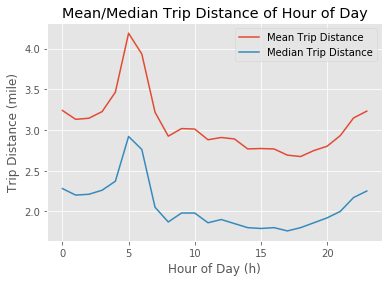

In [9]:
mean_graph=plt.plot(hour_trip.mean()['Trip_distance'],label='Mean Trip Distance')
median_graph=plt.plot(hour_trip.median()['Trip_distance'],label='Median Trip Distance')
plt.title('Mean/Median Trip Distance of Hour of Day')
plt.xlabel('Hour of Day (h)')
plt.ylabel('Trip Distance (mile)')
plt.legend()
plt.show()

From the graphs and data above, we can find some interesting stuff: the mean and median mainly follow the same trend, which means the trip distance in every hour period is kind of stable. And the trip distance at around 5-6 am is the longest, which might be due to that people in NYC are on their way for working at that time. Similarly, distance after 20:00 is increasing, which might be that it's the common time for people to go back home in NYC.  

### 3.2 Build prediction model for predicting tip as a percentage of the total fare

Now we arrive at the core part of this tutorial: building a machine learning model for data analysis task. First let's filter invalid tips according to these rules:  
1. Empty or nan rows are invalid
2. Negative tips and fare are invalid
3. If tip>=fare, it's invalid. This is arguable, I mark it as invalid simply because it's kind of counter-intuitive and not common in daily life.

In [10]:
# derived variable for tip percentage about total fare
# First valid tip column and total_fare column to filter invalid data
# checkpoint1: whether there're empty lines in tip and fare

print(len(green_trip_pd))
check_tip=green_trip_pd['Tip_amount'].replace('',np.nan)
print('nan column:',check_tip.isnull().sum())

check_fare=green_trip_pd['Total_amount'].replace('',np.nan)
print('nan column:',check_fare.isnull().sum())

#checkpoint2: if tip<0 or fare<0, then it's invalid
check_tip=green_trip_pd[green_trip_pd['Tip_amount']<0]['Tip_amount']
check_fare=green_trip_pd[green_trip_pd['Total_amount']<0]['Total_amount']
print('invalid tip:',len(check_tip),"invalid fare:",len(check_fare))

# check point3: if tip>fare then it's invalid 
checkvalid=green_trip_pd[(green_trip_pd['Tip_amount']>=green_trip_pd['Total_amount'])]
print('unbalance tip and fare:',len(checkvalid))




1494926
nan column: 0
nan column: 0
invalid tip: 38 invalid fare: 2417
unbalance tip and fare: 6742


Then let's remove the invalid data from our dataframe:

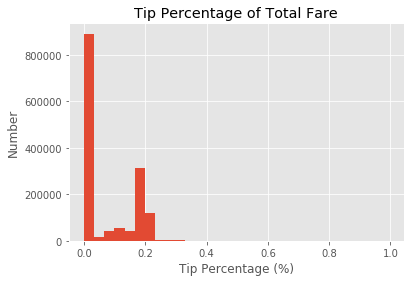

In [11]:
# add a column about tip proportion first
green_trip_pd['tip_prop']=green_trip_pd['Tip_amount']/green_trip_pd['Total_amount']
valid_trip=green_trip_pd[(green_trip_pd['Total_amount']>0)&(green_trip_pd['Tip_amount']>=0)&(green_trip_pd['Tip_amount']<green_trip_pd['Total_amount'])]

tip_prop=valid_trip['tip_prop']

# Now derive our variable
# print('derived tip proportion data:')
# print(tip_prop.describe(),len(tip_prop))

plt.hist(tip_prop,bins=30)
plt.title('Tip Percentage of Total Fare')
plt.xlabel('Tip Percentage (%)')
plt.ylabel('Number')
plt.show()


In this way we successfully obtain a kind of "clean" variable about the tip percentage in our data set. We can find that most of the tips are 0, which means tips might not be needed in most case. However, we should also notice that cash tips are not included in our data set, which might bring some bias towards our conclusion. 

With the valid target output, we'd like to first decide which model to build. It's a problem of logistic regression. And since we have so much useful data, I have the condition to build a complex and more reliable model with enough training data. So the multi-layer neuron network should be a good choice. Neuron network which is ideal for dealing with noise is an excellent model for infering the relationship between multiple variables.


Then we just need to do two things:  
1. Feature engineering, including filtering features, get new features composed of current features
2. Seperate data into training set, valid set and test set for training.

Let's move on to these steps.



First let's transfer some data types into feedable forms just like what we did in previous section. For the time, I'll leave out year, month and day since it's only a one-month dataset. I'll use seconds to represent the time.

In [12]:
# pre-process data - step one: transform data type into countable ones
green_trip_pd['dropoff_second']=green_trip_pd['Lpep_dropoff_datetime'].apply(lambda x:x.hour*3600+x.minute*60+x.second)
green_trip_pd['pickup_second']=green_trip_pd['lpep_pickup_datetime'].apply(lambda x:x.hour*3600+x.minute*60+x.second)
# print(green_trip_pd.shape)

Next let's take a look at data attributes of all columns and exclude those unimportant ones:

In [13]:
# Analyze data column
print(green_trip_pd.describe(),green_trip_pd.columns,len(green_trip_pd.columns))
# display incomplete, just to make sure display all [this is a bad improvement, need to update if time permitted]
columns=['Extra', 'MTA_tax','Tip_amount']
print(green_trip_pd[columns].describe())

/Users/lazy/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


           VendorID  Store_and_fwd_flag    RateCodeID  Pickup_longitude  \
count  1.494926e+06        1.494926e+06  1.494926e+06      1.494926e+06   
mean   1.782045e+00        5.842430e-03  1.097653e+00     -7.383084e+01   
std    4.128570e-01        7.621220e-02  6.359437e-01      2.776082e+00   
min    1.000000e+00        0.000000e+00  1.000000e+00     -8.331908e+01   
25%    2.000000e+00        0.000000e+00  1.000000e+00     -7.395961e+01   
50%    2.000000e+00        0.000000e+00  1.000000e+00     -7.394536e+01   
75%    2.000000e+00        0.000000e+00  1.000000e+00     -7.391748e+01   
max    2.000000e+00        1.000000e+00  9.900000e+01      0.000000e+00   

       Pickup_latitude  Dropoff_longitude  Dropoff_latitude  Passenger_count  \
count     1.494926e+06       1.494926e+06      1.494926e+06     1.494926e+06   
mean      4.069114e+01      -7.383728e+01      4.069291e+01     1.370598e+00   
std       1.530882e+00       2.677911e+00      1.476698e+00     1.039426e+00   
min 

From the results above, we can find that most values in column Ehail_fee are empty, and column improvement_surcharge, MTA_tax, Store_and_fwd_flag have a relatively low variance. So we're gonna drop them. In addition, since we already have pickup/dropoff time and tip proportion, we can drop lpep_pickup_datetime, Lpep_dropoff_datetime, hour, Tip_amount as well.

In [14]:
# Make a copy of the original data for later use
inputdata=green_trip_pd.copy()
# pre-process data - step two: leave out useless columns
inputdata=inputdata.drop(['MTA_tax','Ehail_fee','improvement_surcharge','hour','Store_and_fwd_flag','lpep_pickup_datetime', 'Lpep_dropoff_datetime','Tip_amount'],axis=1)

Then we drop those empty/None data:

In [15]:
inputdata=inputdata.replace('',np.nan)
print(inputdata.isnull().sum())

VendorID                0
RateCodeID              0
Pickup_longitude        0
Pickup_latitude         0
Dropoff_longitude       0
Dropoff_latitude        0
Passenger_count         0
Trip_distance           0
Fare_amount             0
Extra                   0
Tolls_amount            0
Total_amount            0
Payment_type            0
Trip_type               4
tip_prop             4172
dropoff_second          0
pickup_second           0
dtype: int64


And let's delete them to clean the dataset.

In [16]:
# Here we find a small bug: the column name Trip_type has a blank! For easier process in later steps I decide to eliminate it.
inputdata.rename(columns=lambda x:x.strip(),inplace=True)
# pre-process data - step three: replace empty columns
inputdata.dropna(inplace=True)


Finally we'll drop those invalid rows based on similar "valid" rules above:

In [17]:
# print(len(inputdata))
# pre-process data - step four: filter unreasonable data
t_f_cond=(inputdata['tip_prop']>=0)&(inputdata['tip_prop']<1)
p_c=(inputdata['Passenger_count']>=0)
toll=(inputdata['Tolls_amount']>=0)
dis=(inputdata['Trip_distance']>=0)
valid_time=(inputdata['dropoff_second']>=inputdata['pickup_second'])
inputdata=inputdata[t_f_cond&p_c&toll&dis&valid_time]
print(len(inputdata),len(inputdata.columns))
print(inputdata.dtypes)

1466059 17
VendorID               int64
RateCodeID             int64
Pickup_longitude     float64
Pickup_latitude      float64
Dropoff_longitude    float64
Dropoff_latitude     float64
Passenger_count        int64
Trip_distance        float64
Fare_amount          float64
Extra                float64
Tolls_amount         float64
Total_amount         float64
Payment_type           int64
Trip_type            float64
tip_prop             float64
dropoff_second         int64
pickup_second          int64
dtype: object


Now we have a valid data set (not strictly) and we can build our training set now. 

Let's seperate input and labels first. One key thing here is that, since we're using multi-layer neuron network, in order to better calculate the loss & gradient and make results more stable, I'd like to divide my output value from a real value in (0,1) into 20 classes between 0 and 1 divided by 0.05 per step. In this way we support one-hot output, and can use CrossEntropy to calculate the final loss and get a more stable gradient.

In [18]:
# classify tip proportion into 20 classes between (0,1): (0,0.05,0.1...)
inputlabels=inputdata['tip_prop'].apply(lambda x:math.floor(x*20))
inputdata.drop('tip_prop',axis=1,inplace=True)

At last let's seperate the data into training set, validation set and test set. We have about 1,400,000 data, I'll use 300,000 for training, 30,000 for hold-out validation and 10000 for testing using the processed data above.

In [19]:
train_size=300000
dev_size=30000
test_size=10000
# First split the processed data into training set, validation set, and test set
train_data=inputdata.iloc[:train_size,:].as_matrix()
train_label=inputlabels.iloc[:train_size].as_matrix()
# print(train_data.shape,train_label.shape)
dev_data=inputdata.iloc[train_size:train_size+dev_size,:].as_matrix()
dev_label=inputlabels.iloc[train_size:train_size+dev_size].as_matrix()
# print(dev_data.shape,dev_label.shape)
test_data=inputdata.iloc[train_size+dev_size:train_size+dev_size+test_size,:].as_matrix()
test_label=inputlabels.iloc[train_size+dev_size:train_size+dev_size+test_size].as_matrix()
# print(test_data.shape,test_label.shape)

For the structure of my neuron network, I'll give a short explanation:

1. It's a three hidden layers preceptron in Pytorch with Relu rather than sigmoid, since ReLu trains faster and can leviate gradient vanishing/exploding problems.

2. For loss function I choose Cross-entropy because it's reliable for regression tasks like this and provide more stable gradient than others MSE.

3. I choose mini-batch SGD with learning rate decay for fast training speed and stable loss decrease in 20 epoch. The trainig data is shuffled at every epoch. Xavier initialization is used for a good start point.

4. Batch normalization, early stop and learning rate decay are used as optimization for avoiding overfitting and jittering.


5. Possible improvement : momentum, regularization, dropout, or Adam. Feel free to try.

Below are my training models and training/validation/testing process.

In [20]:
# Build my 3-hidden layer neuron network

lr=0.5
batch_size=512
inputsize=16
outputsize=20
epoch=20
train_size=300000
dev_size=30000
test_size=10000

class mynet(torch.nn.Module):
    def __init__(self,inputsize,outputsize):
        super().__init__()
        self.to_hidden1_bn = torch.nn.BatchNorm1d(inputsize)
        self.to_hidden1=torch.nn.Linear(inputsize,80)
        self.hidden1_Relu=torch.nn.ReLU()
        self.to_hidden2_bn = torch.nn.BatchNorm1d(80)
        self.to_hidden2=torch.nn.Linear(80,60)
        self.hidden2_Relu=torch.nn.ReLU()
        self.to_hidden3_bn = torch.nn.BatchNorm1d(60)
        self.to_hidden3=torch.nn.Linear(60,40)
        self.hidden3_Relu = torch.nn.ReLU()
        self.to_output=torch.nn.Linear(40,outputsize)
    def forward(self,inputval):
        hidden1=self.hidden1_Relu(self.to_hidden1(self.to_hidden1_bn(inputval)))
        hidden2=self.hidden2_Relu(self.to_hidden2(self.to_hidden2_bn(hidden1)))
        hidden3 = self.hidden3_Relu(self.to_hidden3(self.to_hidden3_bn(hidden2)))
        return self.to_output(hidden3)
    
def to_variable(tensor):
    # Tensor -> Variable (on GPU if possible)
    if torch.cuda.is_available():
        # Tensor -> GPU Tensor
        tensor = tensor.cuda()
    return torch.autograd.Variable(tensor)

def to_tensor(numpy_array):
    # Numpy array -> Tensor
    return torch.from_numpy(numpy_array)

def init_xavier(m):
    if type(m) == torch.nn.Linear:
        fan_in = m.weight.size()[1]
        fan_out = m.weight.size()[0]
        std = np.sqrt(2.0 / (fan_in + fan_out))
        m.weight.data.normal_(0,std)
        m.bias.data.zero_()
        
def inference(model,loader,nums):
    correct=0
    for (data,label) in loader:
        inputs=to_variable(data.view(-1,inputsize))
        outputs=model(inputs)
        labels=to_variable(label)
        pred=outputs.data.max(1,keepdim=True)[1]
        predicted=pred.eq(labels.data.view_as(pred))
        correct+=predicted.sum()
    return correct/nums

def predict(model,test_loader,testsize):
    results=[]
    correct=0
    for index,(data,label) in enumerate(test_loader):
        inputs=to_variable(data.view(-1,inputsize))
        outputs=model(inputs)
        labels=to_variable(label)
        pred=outputs.data.max(1,keepdim=True)[1]
        predicted=pred.eq(labels.data.view_as(pred))
        correct+=predicted.sum()
        results.append(pred.numpy()/20.0)
    results=np.concatenate(results)
    return correct/testsize,results

In [21]:
class trainer():
    def __init__(self,model,optimizer,loss,trainloader):
        self.model=model
        self.optimizer=optimizer
        self.loss=loss
        if torch.cuda.is_available():
            self.loss=self.loss.cuda()
        self.trainloader=trainloader
        
    def stopcon(self):
        def deriv(ns):
            return [ns[i+1]-ns[i] for i in range(len(ns)-1)]
        return sum(deriv(self.errors['val_error'][-10:]))>0
    
    def save_model(self,path):
        torch.save(self.model.state_dict(),path)
        
    def train(self,epoch,val_loader,val_size,train_size):
        print("Start training...")
        print(self.optimizer,self.loss)
        print(len(self.trainloader), self.trainloader)
        self.errors={'val_error':[],'loss':[],'train_error':[]}
        schedule=StepLR(self.optimizer,step_size=1,gamma=0.5)
        for i in range(epoch):
            if self.stopcon():
                return
            correct = 0
            epoch_loss = 0
            t1=time.time()
            schedule.step()
            for index,(data,label) in enumerate(self.trainloader):
                self.optimizer.zero_grad()
                inputs=to_variable(data.view(-1,inputsize))
                outputs=self.model.forward(inputs)
                labels=to_variable(label)
                loss=self.loss(outputs,labels)
                loss.backward()
                self.optimizer.step()
                pred = outputs.data.max(1, keepdim=True)[1]
                predicted = pred.eq(labels.data.view_as(pred))
                correct += predicted.sum()
                epoch_loss+=loss.data[0]
            t2=time.time()
            total_loss=epoch_loss/train_size
            train_error=1-correct/train_size
            val_accu=inference(self.model,val_loader,val_size)
            print('epoch:{0},loss:{1:.8f},validate accuracy:{2:.8f},train error:{3:.8f},time:{4:.2f}'.format(i+1,total_loss,val_accu,train_error,t2-t1))
            self.errors['val_error'].append(1-val_accu)
            self.errors['train_error'].append(train_error)
            self.errors['loss'].append(total_loss)
        self.model.eval()           

In [22]:
# Training preparation
mn = mynet(inputsize, outputsize)
if torch.cuda.is_available():
    mn=mn.cuda()
mn.apply(init_xavier)
print('cuda?,',torch.cuda.is_available())

trainset=TensorDataset(to_tensor(train_data).float(),to_tensor(train_label))
train_loader=DataLoader(trainset,batch_size=batch_size,shuffle=True)

devset=TensorDataset(to_tensor(dev_data).float(),to_tensor(dev_label))
dev_loader=DataLoader(devset,batch_size=batch_size,shuffle=True)

testset=TensorDataset(to_tensor(test_data).float(),to_tensor(test_label))
test_loader=DataLoader(testset,batch_size=batch_size,shuffle=False)

mlp=trainer(mn,torch.optim.SGD(mn.parameters(),lr=lr),torch.nn.CrossEntropyLoss(),train_loader)
mlp.train(epoch,dev_loader,dev_size,train_size)
mlp.save_model('tip_proportion_predictor.pt')


cuda?, False
Start training...
<torch.optim.sgd.SGD object at 0x11bb3a518> CrossEntropyLoss(
)
586 <torch.utils.data.dataloader.DataLoader object at 0x11bb3acf8>
epoch:1,loss:0.00079109,validate accuracy:0.89416667,train error:0.13998333,time:3.94
epoch:2,loss:0.00031950,validate accuracy:0.92613333,train error:0.06210333,time:4.40
epoch:3,loss:0.00022857,validate accuracy:0.93760000,train error:0.04606667,time:4.10
epoch:4,loss:0.00020475,validate accuracy:0.94166667,train error:0.04218667,time:3.73
epoch:5,loss:0.00019528,validate accuracy:0.93623333,train error:0.04005000,time:3.91
epoch:6,loss:0.00018372,validate accuracy:0.94713333,train error:0.03767667,time:3.87
epoch:7,loss:0.00018564,validate accuracy:0.94496667,train error:0.03808333,time:3.86
epoch:8,loss:0.00018587,validate accuracy:0.94403333,train error:0.03802667,time:3.67
epoch:9,loss:0.00018306,validate accuracy:0.94236667,train error:0.03767000,time:3.65
epoch:10,loss:0.00018398,validate accuracy:0.93946667,train erro

accuracy 0.949


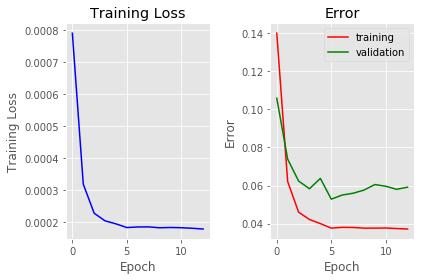

In [23]:
accuracy,results=predict(mlp.model,test_loader,test_size)
print('accuracy',accuracy)

plt.figure(1)
plt.subplot(121)
plt.plot(mlp.errors['loss'], 'b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss')

plt.subplot(122)
plt.plot(mlp.errors['train_error'], 'r', label='training')
plt.plot(mlp.errors['val_error'], 'g', label='validation')
plt.title('Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.tight_layout()
plt.show()

Notice when validation error is stable the training error is still decreasing. This might indicate overfitting is happenning. L2 regularization can be used do deal with it(open to you!).  

Another interesting thing about the graph is that our model has a really high accuracy after only 20 epoches training, this is a little bit unusual; but if we take a look at the our predicting results, we can see:

In [24]:
count=0
for i in results:
    if i[0]==0:
        count+=1
print('0 percentage:',count/len(results))

0 percentage: 0.6377


64% results are 0! Remember from the previous section, we have known that the majority (over 50%, 60%-75%) tip proportion are 0. This might account for the unusual high predicting accuracy. The training data is kind of biased, more unbiased training examples need to be provided to find a more stable relationship.

## 4. Summary and reference

To conclude, this tutorial focuses on the analysis of the NYC taxi trip data. Thanks for reading this long and verbose tutorial, I hope it can give you some inspiration in dealing with pratical data science problems. Any suggestions and advices about this tutorial will be greatly appreciated.

At last I'd like to give you some reference for solving possible problems in this tutorial and supporting further exploration about this interesting dataset.

1. Anaconda: https://www.anaconda.com/download/
2. Python 3: https://www.python.org/downloads/
3. Pytorch : http://pytorch.org/
4. Pandas documents: https://pandas.pydata.org/pandas-docs/stable/
5. Matplotlib: https://matplotlib.org/users/index.html
6. NYC TLC dataset description: http://www.nyc.gov/html/tlc/html/about/about.shtml
7. NYC TLC raw dataset: http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml